In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier

2024-01-31 18:29:51.409101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 18:29:51.409167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 18:29:51.411010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 18:29:51.420283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 18:29:52.426527: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2_custom/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:1000]}

In [39]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']

label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced_further,
                                      with_labels=True,
                                      train_val_split=0.8, input_stride=2, padding='zero',
                                      pad_location_labels=0,
                                      input_history_steps=1, input_future_steps=128, seed=69)


=========================Creating Generator=======================
Seed: 69
nTrain: 1360 nVal: 340 (0.80)
Padding: zero
Scaling: True 
Horizons: 1-128 @ stride 2
Sin-Transformed features: []
=========================Finished Generator=======================


In [40]:
train_combined, val_combined = ds_gen.get_datasets(batch_size=512, 
                                                   label_features=['EW_Type', 'NS_Type'], 
                                                   with_identifier=False, 
                                                   only_nodes=True, 
                                                   shuffle=True, 
                                                   stride=1)

print(train_combined.element_spec)


(TensorSpec(shape=(None, 65, 6), dtype=tf.float64, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 65, 6)]              0         []                            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 60, 32)               1184      ['Input[0][0]']               
                                                                                                  
 conv1d_20 (Conv1D)          (None, 55, 32)               6176      ['conv1d_19[0][0]']           
                                                                                                  
 conv1d_21 (Conv1D)          (None, 50, 32)               6176      ['conv1d_20[0][0]']           
                                                                                            

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


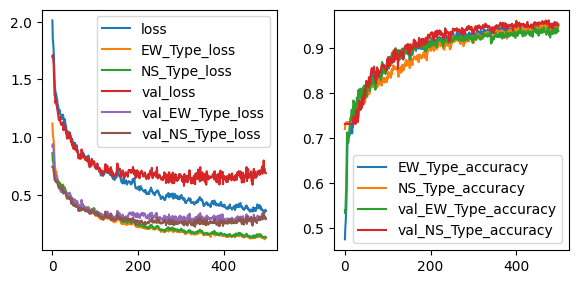

In [41]:
# train_combined, val_combined = ds_gen.get_datasets(batch_size=512, label_features=['EW_Type', 'NS_Type'], with_identifier=False, shuffle=True, stride=4)
# print(train_combined.element_spec)

#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[16], l2_reg=0.0001, input_dropout=0.1, mixed_dropout=0.5, lr_scheduler=[10000,0.9], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[1], l2_reg=0.00001, mixed_dropout=0.2, lr_scheduler=[70000,0.9], seed=0)

dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[[32,6],[32,6],[32,6]], 
                                       dense_layers=[16,8], l2_reg=0.0002, input_dropout=0.1, mixed_dropout=0.5, 
                                       lr_scheduler=[0.006, 500, 0.9], seed=0)

dense_model.summary()

# temporary fix to allow class weights
# train_combined = train_combined.map(lambda x,y:(x,y[f'EW_Node']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Node'])) 

w_0 = 21.3
w_1 = 22.0
w_2 = 16.0
w_3 = 2.9

hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=500, verbose=2, plot_hist=True,
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

In [15]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))
dense_model.model.save('submission/models/ew_ns_classifier_oneshot_cnn.hdf5')

#0.6442 0.7354 ~0.85

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 63, 6)]              0         []                            
                                                                                                  
 flatten (Flatten)           (None, 378)                  0         ['Input[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 378)                  0         ['flatten[0][0]']             
                                                                                                  
 dense (Dense)               (None, 32)                   12128     ['dropout[0][0]']             
                                                                                              

'/home/david/Code/splid-challenge'

In [10]:
pickle.dump(ds_gen.scaler, open('models/ew_ns_classifier_scaler_new.pkl', 'wb'))

In [ ]:
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=10, verbose=2, plot_hist=True, callbacks=[])

In [6]:
#dense_model.model.save('models/ew_ns_classifier.hdf5')

In [42]:
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],
                                object_limit=None,
                                only_nodes=True,
                                verbose=1)

40/40 [==============================] - 0s 4ms/step


In [43]:
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
majority_df = classifier.apply_one_shot_method(preds_df=pred_df, location_df=ground_truth_df)
print(majority_df.head(10))

   ObjectID  TimeIndex Direction Node Type
0         7          0        EW   SS   CK
1         7          0        NS   SS   CK
2        32          0        EW   SS   CK
3        32          0        NS   SS   CK
4        42          0        EW   SS   CK
5        42          0        NS   SS   CK
6        44          0        EW   SS   CK
7        44          0        NS   SS   CK
8        46          0        EW   SS   CK
9        46          0        NS   SS   CK


In [44]:
# ground_truth_df=ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
# majority_df=majority_df.loc[majority_df['TimeIndex']==0]
# ground_truth_df=ground_truth_df.loc[ground_truth_df['Direction']=='EW']
# majority_df=majority_df.loc[majority_df['Direction']=='EW']

# 0.94 with 3-layer cnn and 128@2 horizon
# 0.92 with 3-layer cnn and 256@4 horizon

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'TP: {total_tp} FP: {total_fp}')

# TODO: check for data leakage to val set, if none, either resample test set or remove test set and train with the (highly out of distribution) data
# TODO: retrain EW localizer - it seems like it is for some reason causing all the new FPs
# TODO: in case resubmitted file still performs bad - try using old submission localizer code... and find differences

Precision: 0.94
TP: 1643 FP: 109


In [9]:
print(dense_model.model.optimizer.learning_rate)

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.0014348903>


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

physical_devices = tf.config.list_physical_devices('CPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

2024-01-29 22:44:01.540607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 22:44:01.586390: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 22:44:01.586520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [27]:
challenge_data_dir = Path('dataset/phase_1_v2_custom')
split_dataframes = datahandler.load_and_prepare_dataframes(challenge_data_dir / "train", labels_dir=None)

labels_dir = challenge_data_dir / 'train_labels.csv'

dense_model = tf.keras.models.load_model('submission/models/ew_ns_classifier_new.hdf5')
custom_scaler= pickle.load(open('submission/models/ew_ns_classifier_scaler_new.pkl', 'rb'))

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      input_features=input_features_reduced_further,
                                      with_labels=False,
                                      train_val_split=1.0,
                                      input_stride=2,
                                      padding='none',
                                      pad_location_labels=0,
                                      input_history_steps=1,
                                      input_future_steps=49,
                                      custom_scaler=custom_scaler,
                                      seed=69)
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=True,
                                model_outputs=['EW_Type', 'NS_Type'],
                                object_limit=200,
                                verbose=1)
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
majority_df = classifier.apply_majority_method_legacy(preds_df=pred_df, location_df=ground_truth_df)
majority_df = majority_df.loc[majority_df['TimeIndex'] == 0]


evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'TP: {total_tp} FP: {total_fp}')

# TODO: maybe the test set is just chosen bad? doesn't have any ew nodes...

loading data without labels
=========================Creating Generator=======================
Seed: 69
nTrain: 1700 nVal: 0 (1.00)
Padding: none
Scaling: True (custom scaler)
Horizons: 1-49 @ stride 2
Sin-Transformed features: []
No Labels
=========================Finished Generator=======================
13276/13276 [==============================] - 34s 3ms/step
      ObjectID  TimeIndex  EW_Type_Pred EW_Type  NS_Type_Pred NS_Type  Loc_EW  \
0           18          0             0      CK             0      CK     1.0   
1           18          0             0      CK             0      CK     0.0   
2124        26          0             0      CK             0      CK     1.0   
2125        26          0             0      CK             0      CK     0.0   
4284        31          0             0      CK             0      CK     1.0   

      Loc_NS EW_Node NS_Node  
0        0.0      SS      SS  
1        1.0      na      ID  
2124     0.0      SS      SS  
2125     1.0      na 

In [49]:
a_df = pd.read_csv('submission/tmp_sub.csv').sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
b_df = pd.read_csv('tmp_sub.csv').sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
#a_df = a_df.loc[a_df['TimeIndex']==0]
#b_df = b_df.loc[b_df['TimeIndex']==0]

In [50]:
comps = pd.concat([a_df,b_df]).drop_duplicates(keep=False).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(comps.head(10))
print(a_df.head(5))
print(b_df.head(5))

   ObjectID  TimeIndex Direction
0      1715        484        NS
1      1716        550        NS
2      1717        610        NS
3      1718        665        NS
4      1719        733        NS
5      1720        778        NS
6      1721        836        NS
7      1722       1043        NS
8      1723       1115        NS
9      1724       1025        NS
   ObjectID  TimeIndex Direction
0      1701          0        EW
1      1701          0        NS
2      1702          0        EW
3      1702          0        NS
4      1703          0        EW
   ObjectID  TimeIndex Direction
0      1701          0        EW
1      1701          0        NS
2      1702          0        EW
3      1702          0        NS
4      1703          0        EW


In [6]:
majority_df = classifier.apply_majority_method(preds_df=pred_df, location_df=ground_truth_df)
majority_df = majority_df.loc[majority_df['TimeIndex'] == 0]
evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'TP: {total_tp} FP: {total_fp}')

adding initial nodes manually
adding initial nodes manually
Precision: 0.36
TP: 143 FP: 257


In [7]:
print(majority_df.head(10))

   ObjectID  TimeIndex Direction Node Type
0      1701          0        EW   SS   CK
1      1701          0        NS   SS   CK
2      1702          0        EW   SS   CK
3      1702          0        NS   SS   CK
4      1703          0        EW   SS   CK
5      1703          0        NS   SS   CK
6      1704          0        EW   SS   CK
7      1704          0        NS   SS   CK
8      1705          0        EW   SS   CK
9      1705          0        NS   SS   CK


In [11]:
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],
                                batch_limit=256,
                                verbose=1)
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv').sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)



Cause: could not parse the source code of <function create_prediction_df.<locals>.<lambda> at 0x7f386df6b7f0>: no matching AST found among candidates:
# coding=utf-8
lambda x, y, z: x
# coding=utf-8
lambda x, y: x
# coding=utf-8
lambda x, y, z: z
# coding=utf-8
lambda x, y: y
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function create_prediction_df.<locals>.<lambda> at 0x7f386df6b7f0>: no matching AST found among candidates:
# coding=utf-8
lambda x, y, z: x
# coding=utf-8
lambda x, y: x
# coding=utf-8
lambda x, y, z: z
# coding=utf-8
lambda x, y: y
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function create_prediction_df.<locals>.<lambda> at 0x7f386df6b7f0>: no matching AST found among candidates:
# coding=utf-8
lambda x, y, z: x
# coding=utf-8
lambda x, y: x
# coding=utf-8
lambda x, y, z: z
# coding=ut

In [12]:
majority_df = classifier.apply_majority_method(preds_df=pred_df, location_df=ground_truth_df)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'TP: {total_tp} FP: {total_fp}')

adding initial nodes manually
adding initial nodes manually
Precision: 0.84
TP: 271 FP: 51


In [14]:
print(pred_df.head(10))

   ObjectID  TimeIndex  EW_Type_Pred EW_Type  NS_Type_Pred NS_Type
0        22         24             0      CK             0      CK
1        22         25             0      CK             0      CK
2        22         26             0      CK             0      CK
3        22         27             0      CK             0      CK
4        22         28             0      CK             0      CK
5        22         29             0      CK             0      CK
6        22         30             0      CK             0      CK
7        22         31             0      CK             0      CK
8        22         32             0      CK             0      CK
9        22         33             0      CK             0      CK


In [12]:
ground_truth_df = ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
majority_df = classifier.apply_majority_method(preds_df=pred_df, location_df=ground_truth_df)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_df, participant=majority_df)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'TP: {total_tp} FP: {total_fp}')

Precision: 0.50
TP: 201 FP: 199


In [ ]:
eval_df, gt_df, evaluator = evaluation.evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                 dense_model,
                                                 model_outputs=['EW_Type', 'NS_Type'],
                                                 train=False,
                                                 majority_segment_labels=True,
                                                 with_initial_node=True,
                                                 only_initial_nodes=True)
                                                 
# Dense: worse
# LSTM 40-40@2 same-padding: 0.51
# LSTM 40-40@2 zero-padding: 0.49
# LSTM 80-80@5: 0.49

# TODO: determine class imbalance for the classifier - maybe nodes should be trained without considering SS at all, as it will never be a necessary classification?
# Maybe also really only train on changepoints...
# TODO: for type, maybe take majority value between timesteps?
# -> New approach seems to be much better for initial nodes!

  0%|          | 0/5 [00:00<?, ?it/s]

/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 20%|██        | 1/5 [00:20<01:22, 20.51s/it]

0.9057142857142857 0.8733333333333333


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 40%|████      | 2/5 [00:42<01:03, 21.21s/it]

0.8942857142857144 0.88


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 60%|██████    | 3/5 [01:04<00:43, 21.67s/it]

0.9066666666666667 0.8688888888888888


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 80%|████████  | 4/5 [01:24<00:20, 20.93s/it]

0.9135714285714286 0.8533333333333333


/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
100%|██████████| 5/5 [01:43<00:00, 20.79s/it]

0.9154285714285715 0.8480000000000001
Train:
avg-Precision: 0.92
avg-TP: 320.4 avg-FP: 29.6
Val:
avg-Precision: 0.85
avg-TP: 127.2 avg-FP: 22.8


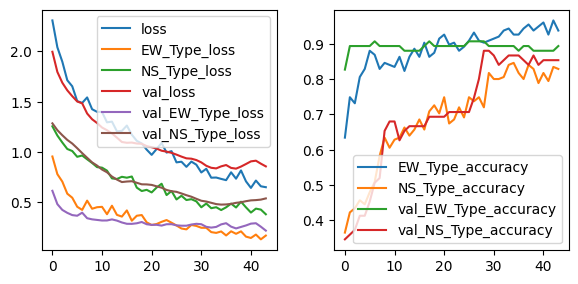

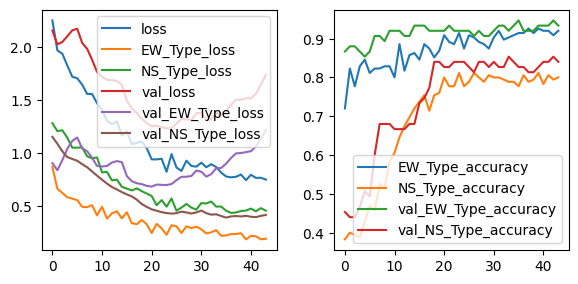

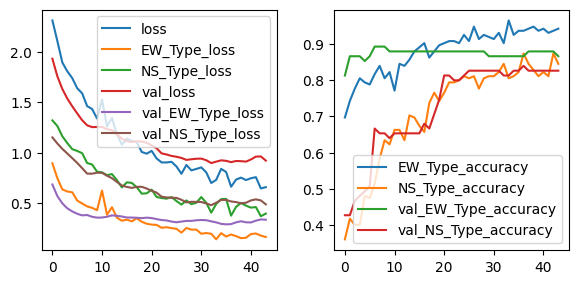

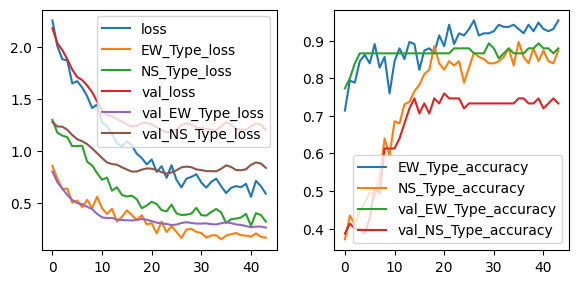

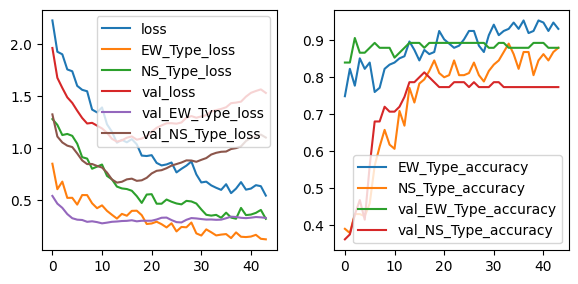

In [21]:
def train_and_eval(seed):
    ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      with_labels=True,
                                      train_val_split=0.7, input_stride=2, padding='none',
                                      pad_location_labels=1,
                                      input_history_steps=1, input_future_steps=400, seed=seed, verbose=0)
    t_ds, v_ds = ds_gen.get_datasets(batch_size=64, label_features=['EW_Type', 'NS_Type'], with_identifier=False, only_nodes=True, shuffle=True, stride=1)

    # temporary fix to allow class weights
    # t_ds = t_ds.map(lambda x,y:(x,y[f'EW_Node']))
    # v_ds = v_ds.map(lambda x,y:(x,y[f'EW_Node'])) 

    w_0_CK = 21.3
    w_1_EK = 22.0
    w_2_HK = 16.0
    w_3_NK = 2.9

    model = prediction_models.Dense_NN(v_ds, conv1d_layers=[], 
                                       dense_layers=[32,16], l2_reg=0.001, input_dropout=0.1, mixed_dropout=0.5,
                                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                                       lr_scheduler=[10000,0.9], seed=0)
    #model = prediction_models.LSTM_NN(t_ds, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
    model.fit(t_ds, val_ds=v_ds, epochs=45, verbose=0, plot_hist=True, callbacks=[])
    scores_t = {}
    scores_v = {}
    for train in [False, True]:
        scores = evaluation.evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                    model,
                                                    model_outputs=['EW_Type', 'NS_Type'],
                                                    train=train,
                                                    majority_segment_labels=False,
                                                    with_initial_node=True,
                                                    only_initial_nodes=True,
                                                    return_scores=True,
                                                    verbose=0)
        if train:
            scores_t = scores
        else:
            scores_v = scores
    return scores_t, scores_v
def k_fold_train_and_eval(n_folds=3):
    
    avg_p_t, avg_tp_t, avg_fp_t = 0.0, 0.0, 0.0
    avg_p_v, avg_tp_v, avg_fp_v = 0.0, 0.0, 0.0
    for fold in tqdm(range(n_folds)):
        scores_t, scores_v = train_and_eval(fold)
        avg_p_t += scores_t['Precision']
        avg_tp_t += scores_t['TP']
        avg_fp_t += scores_t['FP']
        avg_p_v += scores_v['Precision']
        avg_tp_v += scores_v['TP']
        avg_fp_v += scores_v['FP']
        print(avg_p_t/(fold+1.0), avg_p_v/(fold+1.0))
    avg_p_t=avg_p_t/float(n_folds)
    avg_tp_t=avg_tp_t/float(n_folds)
    avg_fp_t=avg_fp_t/float(n_folds)
    avg_p_v=avg_p_v/float(n_folds)
    avg_tp_v=avg_tp_v/float(n_folds)
    avg_fp_v=avg_fp_v/float(n_folds)

    print('Train:')
    print(f'avg-Precision: {avg_p_t:.2f}')
    print(f'avg-TP: {avg_tp_t:.1f} avg-FP: {avg_fp_t:.1f}')
    print('Val:')
    print(f'avg-Precision: {avg_p_v:.2f}')
    print(f'avg-TP: {avg_tp_v:.1f} avg-FP: {avg_fp_v:.1f}')

k_fold_train_and_eval(5)

# 89 86
# 94 89 (500 hoizon, input-stride 1)
# 91 87 (500 hoizon, input-stride 4)
# 90 87 (500 hoizon, input-stride 2)
# 89 87 (500 hoizon, input-stride 4, small af model)
# 91 88 (400 hoizon, input-stride 2, small af model)
# 90 87 (300 hoizon, input-stride 2, small af model)

# TODO: add class weights, esp. EK!

/home/david/Code/splid-challenge/base/prediction_models.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


8/8 [==============================] - 0s 3ms/step
Assuming perfect nodes
Considering ONLY initial nodes
Precision: 0.91
TP: 429 FP: 45


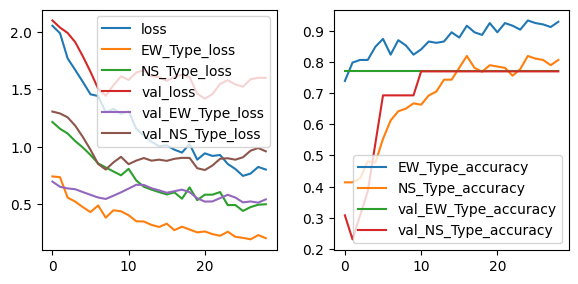

In [24]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      with_labels=True,
                                      train_val_split=0.95, input_stride=2, padding='none',
                                      pad_location_labels=1,
                                      input_history_steps=1, input_future_steps=400, seed=69, verbose=0)
t_ds, v_ds = ds_gen.get_datasets(batch_size=64, label_features=['EW_Type', 'NS_Type'], with_identifier=False, only_nodes=True, shuffle=True, stride=1)

model = prediction_models.Dense_NN(v_ds, conv1d_layers=[], 
                                    dense_layers=[32,16], l2_reg=0.001, input_dropout=0.1, mixed_dropout=0.5,
                                    #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                                    lr_scheduler=[10000,0.9], seed=0)
#model = prediction_models.LSTM_NN(t_ds, input_dropout=0.0, mixed_dropout=0.25, lstm_layers=[32,16], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
model.fit(t_ds, val_ds=v_ds, epochs=30, verbose=0, plot_hist=True, callbacks=[])

scores = evaluation.evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                    model,
                                                    model_outputs=['EW_Type', 'NS_Type'],
                                                    train=True,
                                                    majority_segment_labels=False,
                                                    with_initial_node=True,
                                                    only_initial_nodes=True,
                                                    return_scores=True,
                                                    verbose=1)

In [27]:
model.model.save('models/ss_type_classifier.hdf5')
pickle.dump(ds_gen.scaler, open('models/ss_type_classifier_scaler.pkl', 'wb'))

In [7]:
eval_df, gt_df, evaluator = evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                 dense_model.model,
                                                 model_outputs=['EW_Type', 'NS_Type'],
                                                 train=True,
                                                 with_initial_node=True)

15707/15707 - 39s - 39s/epoch - 2ms/step
Assuming perfect nodes
Precision: 0.95
TP: 449 FP: 25


In [13]:
eval_df = eval_df.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
eval_df

,ObjectID,TimeIndex,EW_Node_Pred,EW_Node,Direction,Type,Node
0,104,99,0.0,AD,EW,NK,AD
1,104,126,0.0,AD,EW,NK,AD
2,107,68,2.0,IK,EW,CK,IK
3,107,74,0.0,AD,EW,NK,AD
4,114,200,2.0,IK,EW,CK,IK
...,...,...,...,...,...,...,...
57,215,912,0.0,AD,EW,NK,AD
58,215,930,2.0,IK,EW,HK,IK
59,221,275,0.0,AD,EW,NK,AD
60,221,298,0.0,AD,EW,NK,AD


In [10]:
print(gt_df.head(20))
print(len(gt_df))

     ObjectID  TimeIndex Direction Node Type
28         10          0        EW   SS   CK
29         10          0        NS   SS   NK
30         10        216        NS   IK   CK
31         10       2171        ES   ES   ES
45         15          0        EW   SS   EK
46         15          0        NS   SS   CK
47         15       2171        ES   ES   ES
64         21          0        EW   SS   HK
65         21          0        NS   SS   HK
66         21       2171        ES   ES   ES
79         26          0        EW   SS   CK
80         26          0        NS   SS   CK
81         26       2207        ES   ES   ES
91         30          0        EW   SS   CK
92         30          0        NS   SS   NK
93         30       2207        ES   ES   ES
109        36          0        EW   SS   CK
110        36          0        NS   SS   NK
111        36       2171        ES   ES   ES
136        45          0        EW   SS   CK
220


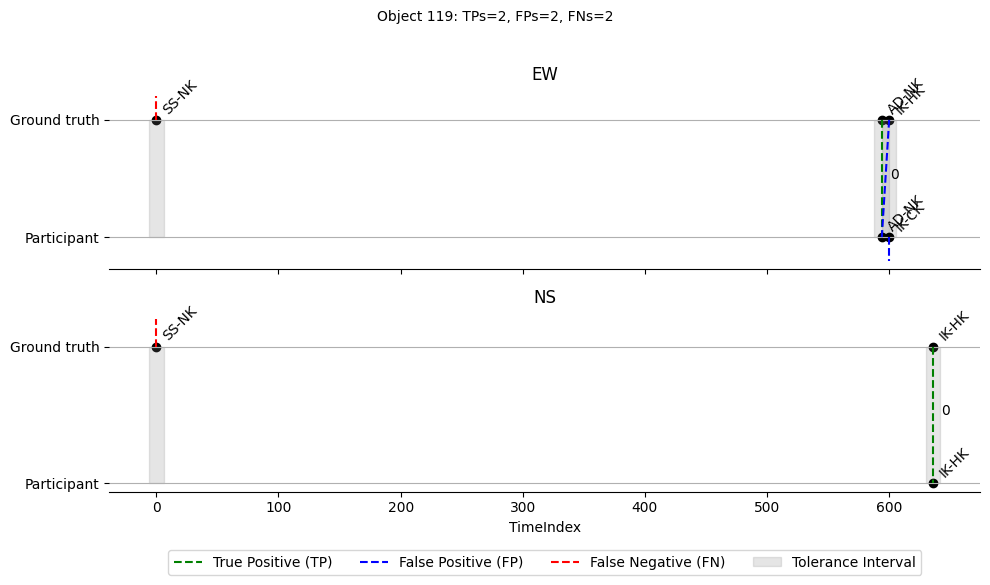

In [9]:
evaluator.plot(119)

In [28]:
t_ds, v_ds = ds_gen.get_datasets(batch_size=None, label_features=['EW_Node'], with_identifier=True, shuffle=False, stride=1)
labels = np.concatenate([element for element in t_ds.map(lambda x,y,z: [y['EW_Node']]).as_numpy_iterator()])
print(labels.shape)
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

(412124,)
{0: 38625, 1: 37452, 2: 51356, 3: 284691}


In [29]:
total = np.sum(counts)
w_0 = (1.0/counts[0])*(total*2.0)
w_1 = (1.0/counts[1])*(total*2.0)
w_2 = (1.0/counts[2])*(total*2.0)
w_3 = (1.0/counts[3])*(total*2.0)
print(f'w_0 = {w_0}')
print(f'w_1 = {w_1}')
print(f'w_2 = {w_2}')
print(f'w_3 = {w_3}')

w_0 = 21.339754045307444
w_1 = 22.008117056498985
w_2 = 16.04969234364047
w_3 = 2.8952372923625966


In [14]:
print(ds_gen.node_label_encoder.transform(['SS', 'ID', 'AD', 'IK']))
print(ds_gen.type_label_encoder.transform(['NK', 'CK', 'EK', 'HK']))

[3 1 0 2]
[3 0 1 2]


In [10]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True)
# LSTM 40-40@2: 0.49
# LSTM 40-40@2 zero-padding: 0.52
# LSTM 80-80@5: 0.51

14/14 [==============================] - 0s 11ms/step
Precision: 0.52
TP: 367 FP: 336


In [10]:
print(eval_df['Type'].unique())

['CK' 'NK']


In [23]:

labels=pd.read_csv(labels_dir)
labels = labels.loc[(labels['ObjectID'].isin(map(int, ds_gen.val_keys)))]
labels = labels.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(len(labels) - (len(ds_gen.val_keys)*3))
print(labels.head(5))

70
   ObjectID  TimeIndex Direction Node Type
0        10          0        EW   SS   CK
1        10          0        NS   SS   NK
2        10        216        NS   IK   CK
3        10       2171        ES   ES   ES
4        15          0        EW   SS   EK
